In [1]:
import os
import urllib.request, json 
import pandas as pd
from IPython.display import HTML
from IPython import display
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model,
    load_petri_model,
    setup_petri_model,
    sample
)
import numpy as np
from typing import Iterable
from pyciemss.utils.interface_utils import (
    assign_interventions_to_timepoints,
    interventions_and_sampled_params_to_interval,
    convert_to_output_format
)
from pyciemss.utils import get_tspan
import matplotlib.pyplot as plt
import torch
from torch import tensor

Utils

In [28]:
def plot_all_QoIs(t, S, E, I, R, D=None, L=None, R0=None, Alpha=None, CFR=None, ax=None):
    if ax is None:
        f, ax = plt.subplots(1,1,figsize=(10,4))
    # N = S[0] + E[0] + I[0] + R[0] + D[0]
    # ax.plot(t, (S/N)*100, 'b--', alpha=0.7, linewidth=2, label='Susceptible')
    # ax.plot(t, (E/N)*100, 'y.', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    # ax.plot(t, (R/N)*100, 'g-.', alpha=0.7, linewidth=2, label='Recovered')

    # if D is not None:
    #     ax.plot(t, D/N, 'k', alpha=0.7, linewidth=2, label='Dead')
    #     ax.plot(t, ((S+E+I+R+D)/N)*100, 'c:', alpha=0.7, linewidth=2, label='Total')
    # else:
    #     ax.plot(t, ((S+E+I+R)/N)*100, 'c:', alpha=0.7, linewidth=2, label='Total')

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Percentage of Population (%)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend(borderpad=2.0)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    if L is not None:
        plt.title("Lockdown after {} days".format(L))
    # plt.show()

    if R0 is not None or CFR is not None:
        f = plt.figure(figsize=(12,4))
    
    if R0 is not None:
        # sp1
        ax1 = f.add_subplot(121)
        ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

        ax1.set_xlabel('Time (days)')
        ax1.title.set_text('R_0 over time')
        # ax.set_ylabel('Number (1000s)')
        # ax.set_ylim(0,1.2)
        ax1.yaxis.set_tick_params(length=0)
        ax1.xaxis.set_tick_params(length=0)
        ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax1.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)

    if Alpha is not None:
        # sp2
        ax2 = f.add_subplot(122)
        ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')

        ax2.set_xlabel('Time (days)')
        ax2.title.set_text('fatality rate over time')
        # ax.set_ylabel('Number (1000s)')
        # ax.set_ylim(0,1.2)
        ax2.yaxis.set_tick_params(length=0)
        ax2.xaxis.set_tick_params(length=0)
        ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax2.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)

    # plt.show()

def aggregate_results(samples_df, num_samples=1):
    # QoIs = ["D_sol", "E_sol", "I_sol", "R_sol", "S_sol"]
    QoIs = []
    for col in samples_df.columns:
        if "_sol" in col:
            QoIs.append(col)
    # print(QoIs)
    all_QoIs = {key: None for key in QoIs}
    for QoI in QoIs:
        # Aggregate results
        # TODO: After they introduce normalized models, remove normalization here.
        # /total_pop * 100
        # total_pop = 0
        # for val in QoIs:
        #     total_pop += samples_df[samples_df["sample_id"] == 0][val].to_numpy()[0]
        all_QoIs[QoI] = [samples_df[samples_df["sample_id"] == i][QoI].to_numpy() for i in range(num_samples)]
    return all_QoIs

# Add '?raw=true' at the end of the link to the file to get the rawgithubusercontent link.
def update_AMR(SEIRD_model_url, SEIRD_model_path):
    with urllib.request.urlopen(SEIRD_model_url) as url:
        json_object = json.load(url)
        with open(SEIRD_model_path, "w") as outfile:
            json.dump(json_object, outfile)

# SCENARIO 2: Multiple Vaccines and Variants

### PART 1
**(A)** TA1/TA2 provide the AMR for a COVID-19 model which includes multiple vaccines and variants of concern. \
Model Source: https://www.nature.com/articles/s41598-022-06159-x \
AMR location: https://github.com/indralab/mira/blob/hackathon/notebooks/hackathon_2023.07/scenario2_a.json \
Model Schematic:

<div>
<img src="attachment:image-3.png" width="400" align="left"/>
</div>

Load the model

In [4]:
# 1b
SEIRD_model_path = "scenario2_a_beta_scale_static.json"
SEIRD_model_url = "https://raw.githubusercontent.com/indralab/mira/hackathon/notebooks/hackathon_2023.07/scenario2_a_beta_scale_static.json"
# NOTE: This is only if you wish to update the AMR.
update_AMR(SEIRD_model_url, SEIRD_model_path)

**(B) TA3 TASK 1:** Perform model simulation over a 14-month period beginning January 1, 2020. Consider only the Wild Type variant, and no vaccination.
 - Use parameter values for wild type from supplementary material
 - 2019 population of Ontario: 14.57 million people
 - Natural death rate $\mu = 2.05e-5$
 - Initial conditions: let $I(0) = 1e-6$, $S(0) = 1 - (I(0) + A(0))$, and all other values be zero
 
Questions: 
1. When do $I(t)$ and $A(t)$ peak, and what is the value of these variables at their peaks? 
2. How do the $I(t)$ and $A(t)$ profiles compare with Fig. 3d, f (below)? 
3. Given that this question assumes only the presence of the wild type variant, do the results seem reasonable?

<div>
<img src="attachment:image-4.png" width="500" align="left"/>
</div>

Simulation Parameters

In [5]:
num_samples = 1
start_time = 0
end_time = 365
num_timepoints = (end_time-start_time)*10 + 1
timepoints = get_tspan(start_time, end_time, num_timepoints)

In [32]:
start_state = {'S': 0.999999, 'V1': 0.0, 'V2': 0.0, 'A': 0.0, 'I': 1e-6, 'R': 0.0, 'AR': 0.0, 'IR': 0.0, 'IV': 0.0, 'R2': 0.0, 'SVR': 0.0}
implement_0day_samples = load_and_sample_petri_model(
        SEIRD_model_path, num_samples, timepoints=timepoints, start_state=start_state)

/Users/vigneshsella/Documents/GitHub/pyciemss/src/pyciemss/PetriNetODE/base.py:330: UserWarning: Parameter (('S', ('identity', 'ido:0000514'), ('vaccination_status', 'vo:0001377')), ('A', ('identity', 'ido:0000511'), ('disease_severity', 'ncit:C3833')), ('I', ('identity', 'ido:0000511')), 'ControlledConversion', 'rate') has value None and will be set to Uniform(0, 1)
  warnings.warn(warnings_string)
/Users/vigneshsella/Documents/GitHub/pyciemss/src/pyciemss/PetriNetODE/base.py:330: UserWarning: Parameter (('V1', ('identity', 'ido:0000514'), ('vaccination_status', 'askemo:0000018')), ('A', ('identity', 'ido:0000511'), ('disease_severity', 'ncit:C3833')), ('I', ('identity', 'ido:0000511')), 'ControlledConversion', 'rate') has value None and will be set to Uniform(0, 1)
  warnings.warn(warnings_string)
/Users/vigneshsella/Documents/GitHub/pyciemss/src/pyciemss/PetriNetODE/base.py:330: UserWarning: Parameter (('V2', ('identity', 'ido:0000514'), ('vaccination_status', 'askemo:0000019')), ('

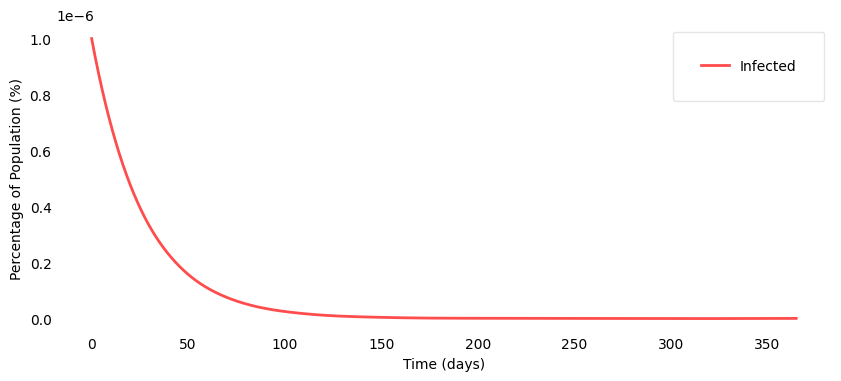

In [33]:
QoIs = aggregate_results(implement_0day_samples, num_samples=num_samples)
plot_all_QoIs(timepoints, S=None, E=None, I=QoIs["I_sol"][0], R=None)

### PART 2 - Extend the model to include multiple strains and (two) vaccine types
**(A) and (B)** TA1/TA2 extract and/or transform the model to include variants and vaccines. \
New schematic for transitions involving susceptible individuals:

<div>
<img src="attachment:image-2.png" width="300" align="left"/>
</div>

**(C) TA3 TASK 2:** Simulate the model over the two-year period from January 1, 2020 to December 31, 2021. 
 - Include the two vaccine types: Pfizer and AstraZeneca
 - Include three COVID-19 variants/strains: Wild Type, Alpha, and Delta (ignore Omicron for now) 
 - Initial conditions: assume the entire population of Ontario is susceptible, except for 15 infected symptomatic individuals
 - Reproduce *Figs. 3a, b, d, and e*

<div>
<img src="attachment:image-2.png" width="300" align="left"/>
</div>

### PART 3
**(D) TA3 TASK 3:** Implement the three additional scenarios described below, and used in the paper to create Fig. 7, and simulate from January 1, 2020 - December 31, 2021: 
1. Assume that a smaller percentage of vaccinations were with Pfizer, but keep the total vaccinations the same as in 2c. Given that the Pfizer vaccine offered stronger protection against all variants, compared to AstraZeneca, what is the impact?
2. Assume a lower provincial vaccination rate compared to the baseline percentage of 74% of the population vaccinated by September 1st, 2021. 
3. Assume less stringent NPIs than what actually took place. 

Qualitatively compare with simulations in Fig. 7, where: 
1. “PZ/AZ,” lower fraction of vaccines being Pfizer (from 95 to 40%), with the reduction made up with AstraZeneca, which offers reduced protection from Delta infections and a longer dosing delay
2. “Vac rate,” vaccination rate reduced by 20%
3. “NPI”, less stringent lockdown measured, with mobility increased by 25%

<div>
<img src="attachment:image.png" width="300" align="left"/>
</div>

### PART 4 - Omicron Variant
**(A)** TA2 simplifies the model structure to consider multiple vaccines, but only the Delta and Omicron variants \
**(B) TA3 TASK 4:** Using epidemiological data for Ontario (https://storage.googleapis.com/covid19-open-data/v3/location/CA_ON.csv) and summary data on Omicron-related characteristics (https://www.cdc.gov/mmwr/volumes/71/wr/mm7137a4.htm) to set relevant model parameters, simulate the simplified model from July to December 2021 and compare with the hypothetical outcomes with the fictitious Neos variant as in Fig. 9

<div>
<img src="attachment:image.png" width="600" align="left"/>
</div>

### PART 5 - Change the model setting to the United States
**(A)** TA1 updates parameter values for the US, and changes vaccine types to (1) Moderna and Pfizer mRNA and (2) Janssen/J&J viral vector vaccine. \
**(B) TA3 TASK 5:** With the updated US-specific AMR, rerun the simulation from January 1, 2020 to December 31, 2021. How do the outcomes compare with Question 2c?